# Модель машиннго обучения - LightAutoML(LAMA) от Сбера!!!

In [1]:
# импортируем библиотеки
import numpy as np # линейная алгебра linear algebra
import pandas as pd # работа с данными / python data analysis library

# библиотека lightautoml
import lightautoml
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка
from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split

# для визуализации
import matplotlib.pyplot as plt
%matplotlib inline

import shap # для визуализации важности признаков

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")

# увеличиваем количество отображаемых столбцов и строк
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 5000)

In [2]:
# %%time
# загружаем данные
data_lama = pd.read_csv("data/data_final.csv", sep=",")

# устанавливаем базовые параметры
N_THREADS = 8
N_FOLDS = 5
RANDOM_STATE = 369
TEST_SIZE = 0.2
TIMEOUT = 7200 # время указано в секундах 3600 секунд = 60 минут = 1 час
TARGET_NAME = "target"

# делим данные на train и test
train_data, test_data = train_test_split(
    data_lama,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# задаем тип задачи, метрики качества
task = Task("reg", loss="mse", metric="mae")

# задаем роли 
roles = {
    "target": "target"
    # "drop": ["Price/sqft"]
}

# описываем модель
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {"n_jobs": N_THREADS, "cv": N_FOLDS, "random_state": RANDOM_STATE}
)

out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)


[17:42:05] Stdout logging level is INFO.
[17:42:05] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[17:42:05] Task: reg

[17:42:05] Start automl preset with listed constraints:
[17:42:05] - time: 7200.00 seconds
[17:42:05] - CPU: 8 cores
[17:42:05] - memory: 16 GB

[17:42:05] Train data shape: (244381, 173)

[17:42:27] Layer 1 train process start. Time left 7177.90 secs
[17:42:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:43:54] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.3517520507577127
[17:43:54] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[17:43:54] Time left 7091.07 secs

[17:45:00] Selector_LightGBM fitting and predicting completed
[17:45:30] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[17:53:39] Time limit exceeded after calculating fold 3

[17:53:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.22888973896169756
[17:53:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting co

In [3]:
%%time
test_predictions = automl.predict(test_data)
print(f"Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}")


Prediction for test_data:
array([[13.117982],
       [12.462563],
       [14.850574],
       ...,
       [12.093814],
       [12.81099 ],
       [14.398902]], dtype=float32)
Shape = (61096, 1)
CPU times: total: 4min 7s
Wall time: 33.8 s


In [5]:
print(f'OOF score: {mean_absolute_error(train_data[roles["target"]].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(test_data[roles["target"]].values, test_predictions.data[:, 0])}')

OOF score: 0.21093251031016882
HOLDOUT score: 0.1985605905567048


In [14]:
# # Замените NaN на некоторое значение, например, на среднее или медиану
# # Для целей таргета (target)
# train_target = train_data[roles['target']].values
# train_target = np.where(np.isnan(train_target), np.nanmedian(train_target), train_target)

# # Для out-of-fold предсказаний
# oof_predictions = out_of_fold_predictions.data[:, 0]
# oof_predictions = np.where(np.isnan(oof_predictions), np.nanmedian(oof_predictions), oof_predictions)

# # Теперь вычисляем OOF score без ошибки
# print(f'OOF score: {mean_absolute_error(train_target, oof_predictions)}')

# # Аналогично обрабатываем данные для HOLDOUT
# test_target = test_data[roles['target']].values
# test_target = np.where(np.isnan(test_target), np.nanmedian(test_target), test_target)

# test_predictions = test_predictions.data[:, 0]
# test_predictions = np.where(np.isnan(test_predictions), np.nanmedian(test_predictions), test_predictions)

# # Теперь вычисляем HOLDOUT score без ошибки
# print(f'HOLDOUT score: {mean_absolute_error(test_target, test_predictions)}')

OOF score: 0.21093251031016882
HOLDOUT score: 0.19856059551239014


In [6]:
from joblib import dump, load
# Сохранение модели в файл
dump(automl, 'model_LAMA.joblib')

['model_LAMA.joblib']

In [ ]:
# # Загрузка модели из файла
# model = load('model.joblib')

## Model analysis

### 1. You can obtain the description of the resulting pipeline:

In [7]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


### 2. Also for this purposes LightAutoML have ReportDeco, use it to build detailed reports:

In [8]:
RD = ReportDeco(output_path = "tabularAutoML_model_report")

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {"n_jobs": N_THREADS, "cv": N_FOLDS, "random_state": RANDOM_STATE}
    )
)

### 3. Feature importances calculation

<Axes: xlabel='Feature'>

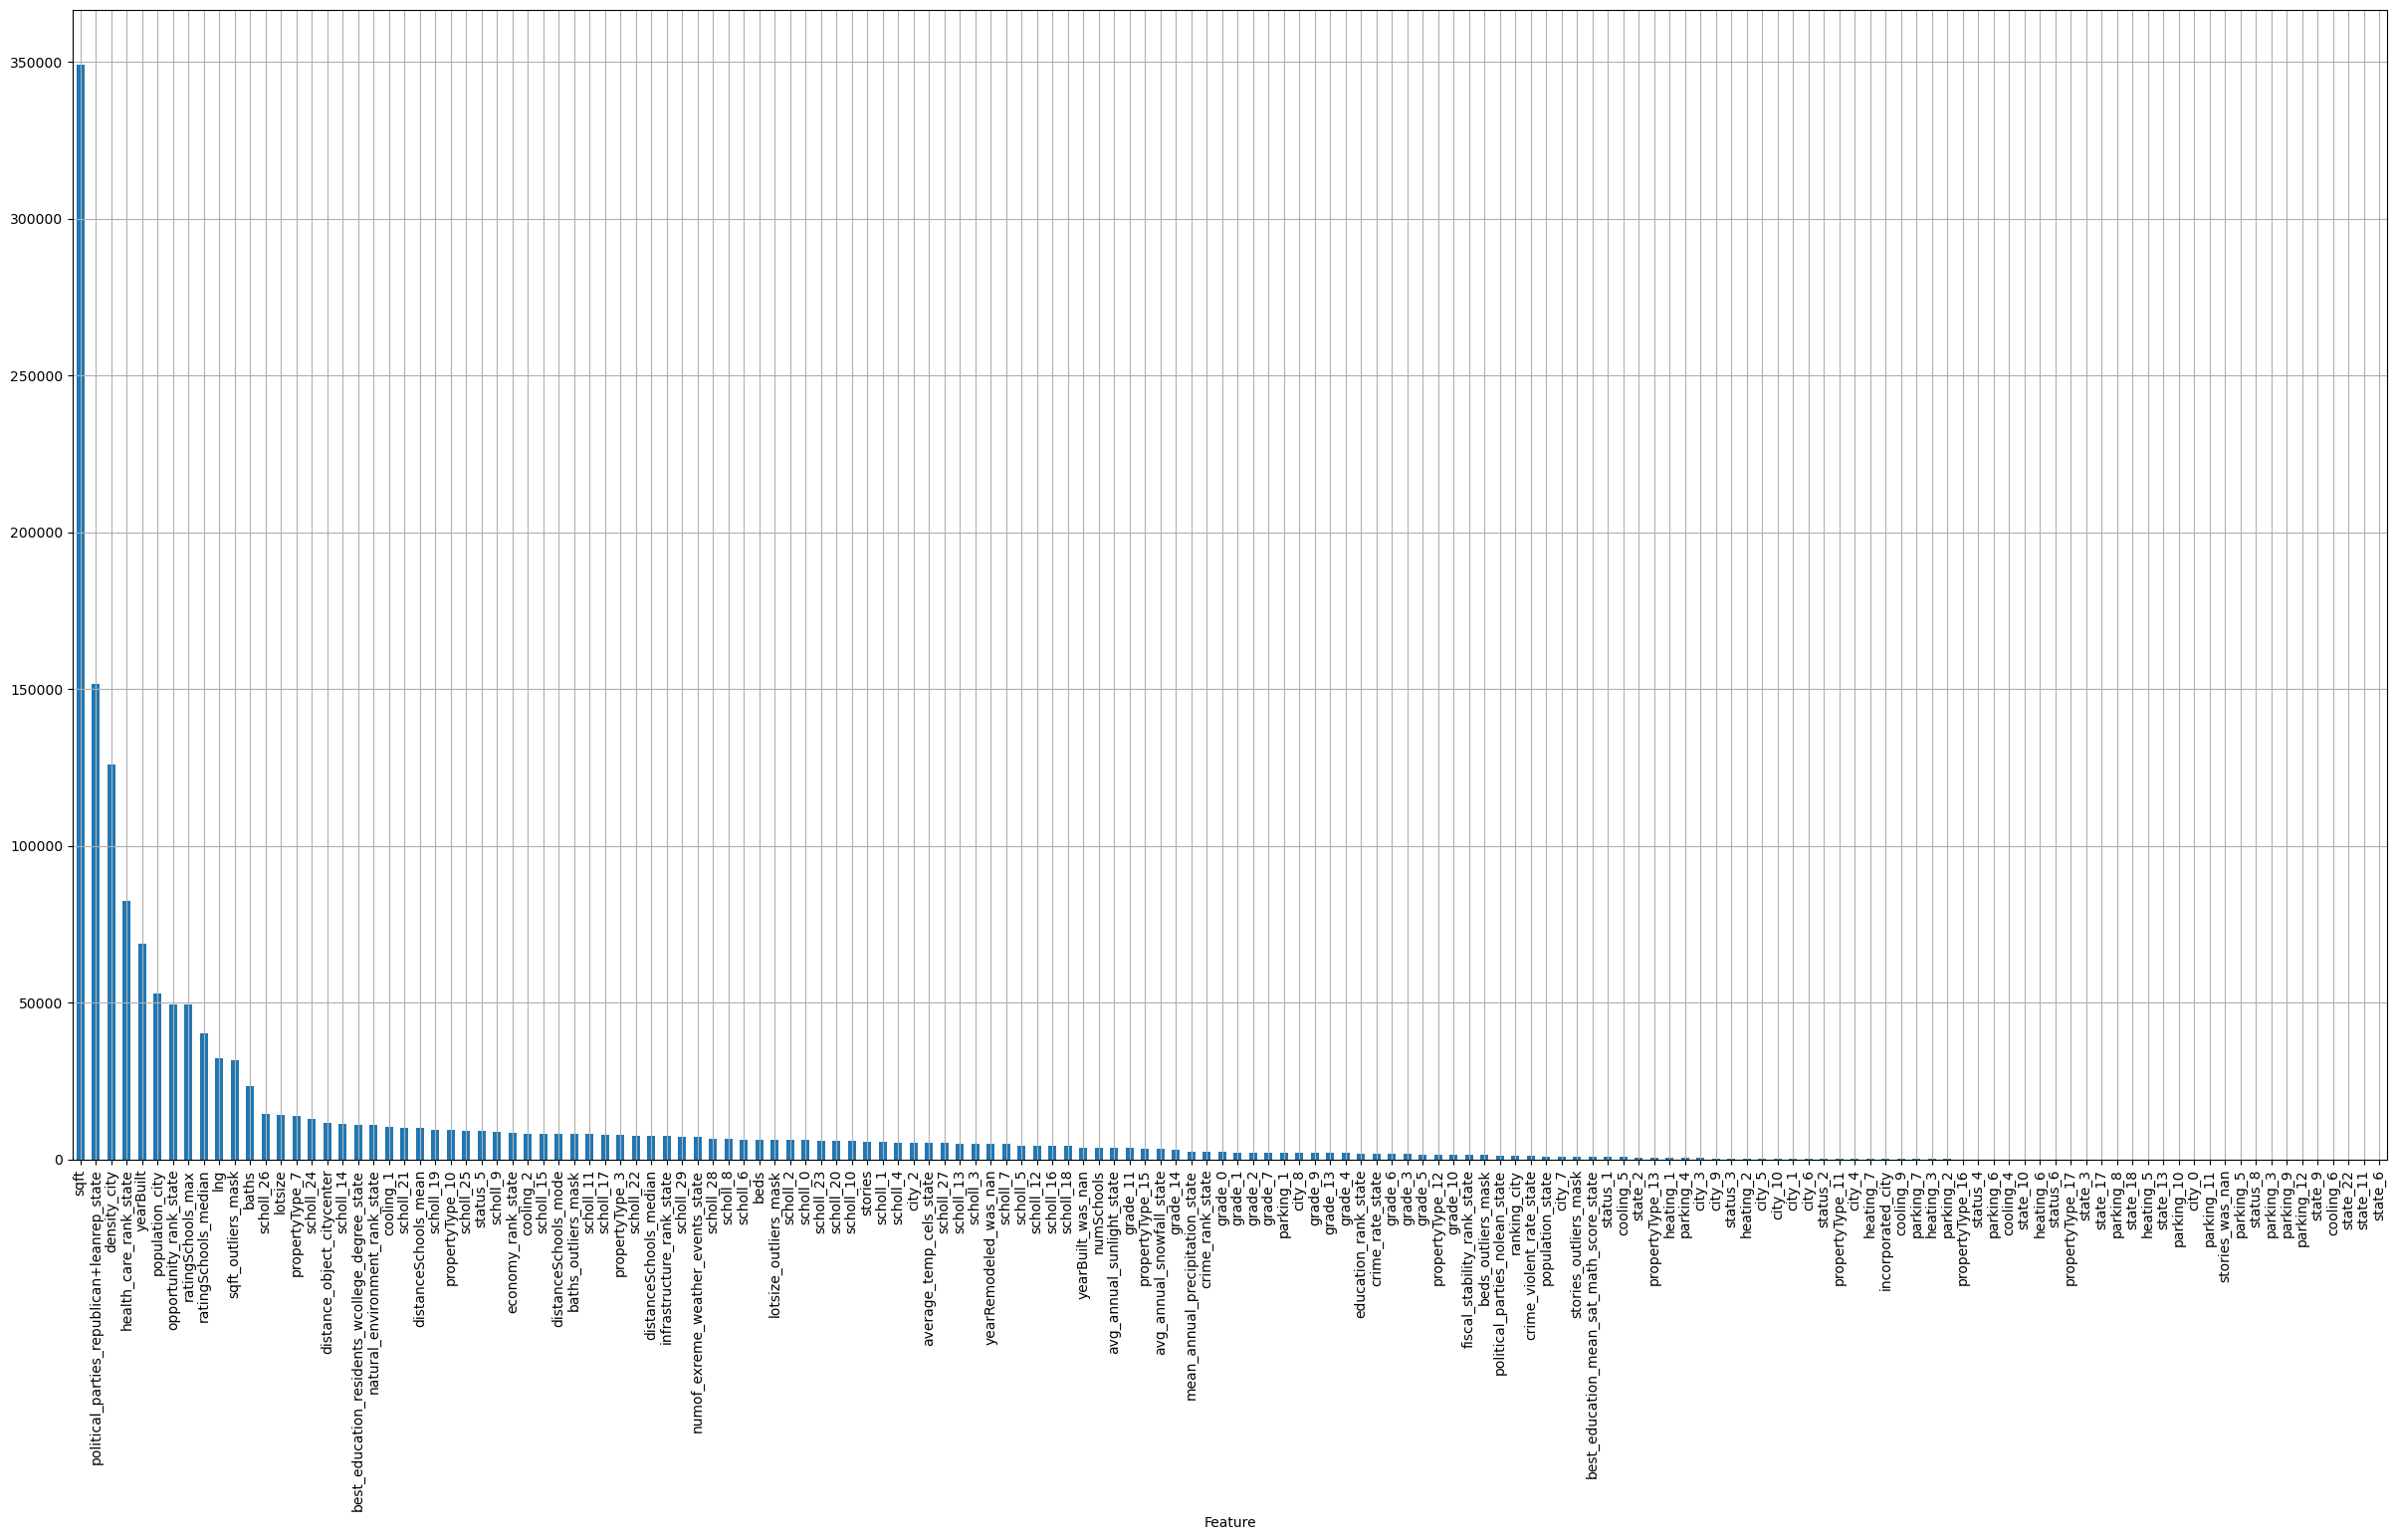

In [9]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores("fast")
fast_fi.set_index("Feature")["Importance"].plot.bar(figsize = (30, 15), grid = True)

### 4. Shapley values example for regression

Значения Шепли (Shapley values) - это концепция из теории коалиционных игр, которая была применена к машинному обучению. В контексте объяснения моделей машинного обучения, значения Шепли используются для оценки важности признаков в предсказаниях модели. Они предоставляют вклад каждого признака в прогноз модели, учитывая взаимодействие между признаками.

Значения Шепли позволяют понять, как каждый признак влияет на предсказания модели, и могут быть полезны для интерпретации результатов модели машинного обучения.

В контексте регрессии, значения Шепли используются для объяснения влияния каждого признака на конкретное значение регрессионной модели.

In [10]:
# выводим информацию о test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61096 entries, 169069 to 119358
Columns: 173 entries, status_1 to distance_object_citycenter
dtypes: float64(64), int64(109)
memory usage: 81.1 MB


In [11]:
# Заменяем типы данных для столбцов
for col in test_data.select_dtypes(include=["float64"]).columns:
    test_data[col] = test_data[col].astype("float32")

for col in test_data.select_dtypes(include=["int64"]).columns:
    test_data[col] = test_data[col].astype("int32")

# Проверяем информацию о памяти после изменения типов данных
print(test_data.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61096 entries, 169069 to 119358
Columns: 173 entries, status_1 to distance_object_citycenter
dtypes: float32(64), int32(109)
memory usage: 40.8 MB
None


#### 4.1. Obtaining shapley estimates

In [ ]:
explainer = SSWARM(automl)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

#### 4.2. Interpretation plots

In [ ]:
# summary plot
shap.summary_plot(shap_values, test_data[explainer.used_feats])

In [ ]:
# # NB!!! Данный код работает с числовыми признаками
# # dependence plots 
# feats = ["baths", "zipcode", "sqft", "lotsize", "beds", "Year built", "name"]
# fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

# for i, feat in enumerate(feats):
#     shap.dependence_plot(feat, shap_values, test_data[explainer.used_feats],
#                          show=False, ax=ax[i], interaction_index="zipcode")

In [ ]:
# individual force plot
shap.force_plot(explainer.expected_value, shap_values[0], test_data[explainer.used_feats].iloc[0], matplotlib=True)

In [ ]:
# overall force plot
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:100], test_data[explainer.used_feats].iloc[:100])

## Справочная информация

Чтобы сохранить параметры модели для использования на другом компьютере, вам нужно сериализовать модель в файл. В зависимости от используемой вами библиотеки Python, способы сохранения могут отличаться. Ниже приведены примеры для некоторых популярных библиотек Python:

1. Scikit-learn:
Вы можете использовать библиотеку joblib или pickle для сохранения модели scikit-learn:

In [ ]:
# from joblib import dump, load 
# # cохранение модели в файл
# dump(model, "model.joblib")
# # загрузка модели из файла
# model = load("model.joblib")

2. TensorFlow/Keras:
Для моделей, созданных с использованием TensorFlow или Keras, вы можете сохранить их с помощью встроенного метода save:

In [ ]:
# from tensorflow.keras.models import load_model

# # Сохранение всей модели в файл HDF5
# model.save('my_model.h5')
# # Загрузка всей модели
# model = load_model('my_model.h5')

3. PyTorch:
Для моделей PyTorch обычно сохраняется словарь состояний:

In [ ]:
# import torch
# # Сохранение словаря состояний модели
# torch.save(model.state_dict(), "model_state.pth")
# # Предполагая, что архитектура модели воссоздана с тем же именем 'model'
# model.load_state_dict(torch.load("model_state.pth"))

Общие советы:
Убедитесь, что вы управляете зависимостями и окружением на другом компьютере так, чтобы оно соответствовало тому, где была обучена модель. Возможно, вам понадобится экспортировать requirements.txt из оригинального окружения с помощью pip freeze и установить его на новой машине:
```
pip freeze > requirements.txt
```
На новом компьютере вы можете воссоздать окружение:
```
pip install -r requirements.txt
```
Также очень важно иметь одинаковые версии библиотек на обоих компьютерах, особенно библиотеки, использованной для построения и обучения вашей модели. Это обеспечит совместимость при загрузке модели.